In [195]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [196]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [197]:
import gc
gc.collect()

2335

In [198]:
Client = pd.read_excel('../data/Client_info_20191118.xlsx',sheet_name='Sheet1')
TPA = pd.read_excel('../data/Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Customer = pd.read_csv('../data/Customer_Data_Request_20191121.csv')

In [199]:
Client_cols = ['Active',
 'Client ID',
 'Account Name',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'Cash']

Customer = Customer.merge(Client[Client_cols],how='left',left_on='Unique_Company_ID',right_on='Client ID')

In [200]:
Perf = pd.read_csv('../data/Performance_Data_Request_20191204.csv')
Perf = Perf.merge(Customer, how='left',on='Unique_Customer_ID')

In [201]:
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format = '%Y%m')
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

Perf.loc[Perf['Order_Amount']=='.','Order_Amount']=0
Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

# Assign Payment Order as a new column
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Treat 151+ ad CO as BAD
Perf['Bad']=0
Perf.loc[Perf['Default_Status'].isin(['151+','Chargeoff']),'Bad']=1
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

In [202]:
# Combine Bad Loss
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status']=='Chargeoff','2os_loss'] = Perf.loc[Perf['Default_Status']=='Chargeoff','Losses']
Perf.loc[Perf['Default_Status']=='151+','2os_loss'] = Perf.loc[Perf['Default_Status']=='151+','Current_Balance']

In [9]:
Perf.shape

(38397651, 54)

### Industry Risk Analysis

- Industry Distribution

In [29]:
Client.pivot_table(values='Client ID', index='Industry',
                   columns='Active', aggfunc='count', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active,Consolidated,Inactive,Split,Terminated,Y,All
Industry,,,,,,
All,10,2,5,163,334,514
Health Care and Social Assistance,4,0,0,42,94,140
Manufacturing,0,0,3,28,47,78
Retail Trade,1,0,0,8,26,35
Educational Services,0,1,0,8,21,30
"Professional, Scientific, and Technical Services",1,0,0,9,21,31
Local Government/Associations,1,1,0,7,18,27
Finance and Insurance,0,0,0,5,15,20
State Government/Associations,2,0,0,5,12,19


In [30]:
Customer.pivot_table(values='Unique_Customer_ID', index='Industry',
                     columns='Active', aggfunc='count', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active,Consolidated,Split,Terminated,Y,All
Industry,,,,,
All,1043,2975,55509,526777,586304
Health Care and Social Assistance,191,0,5768,138554,144513
Federal Government/Associations,0,0,89,92410,92499
Retail Trade,59,0,2217,86388,88664
Manufacturing,0,2002,3507,41084,46593
State Government/Associations,793,0,4719,40312,45824
Accommodation and Food Services,0,0,2818,17844,20662
Transportation and Warehousing,0,0,82,15527,15609
Finance and Insurance,0,0,1171,15010,16181


In [31]:
Customer.pivot_table(values='Assigned_Spending_Limit', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active,Consolidated,Split,Terminated,Y,All
Industry,,,,,
"Mining, Quarrying, and Oil and Gas Extraction",0.000000,0.000000,2284.530201,7005.775439,3042.589296
Construction,0.000000,0.000000,0.000000,6964.210345,6964.210345
Transportation and Warehousing,0.000000,0.000000,598.963415,6015.680106,5987.224037
Federal Government/Associations,0.000000,0.000000,2995.056180,5559.699437,5557.231808
Utilities,0.000000,0.000000,1272.142857,5339.096482,5071.784977
State Government/Associations,3536.891551,0.000000,2019.876033,5104.373264,4759.602937
Health Care and Social Assistance,4064.031414,0.000000,1644.881380,5031.170057,4894.733636
Engineering,0.000000,0.000000,0.000000,4740.000000,4740.000000
Educational Services,0.000000,0.000000,1765.969591,4642.573716,4583.536354


In [32]:
Customer.pivot_table(values='Customer_Salary', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True).sort_values('Y',ascending = False)

Active,Consolidated,Split,Terminated,Y,All
Industry,,,,,
Accommodation and Food Services,0.000000,0.000000,37732.510128,296375.297181,262885.165205
Construction,0.000000,0.000000,0.000000,94452.379310,94452.379310
"Mining, Quarrying, and Oil and Gas Extraction",0.000000,0.000000,47052.165909,81481.575746,57435.638717
Engineering,0.000000,0.000000,0.000000,61430.280000,61430.280000
Federal Government/Associations,0.000000,0.000000,56085.494691,59861.636879,59858.124431
Management of Companies and Enterprises,0.000000,0.000000,34329.788235,55653.937463,54550.964227
All,33705.076894,40809.563462,40255.687306,54381.895265,53277.954328
Finance and Insurance,0.000000,0.000000,39283.859539,51807.226921,51437.868178
Utilities,0.000000,0.000000,79999.500000,51646.998207,51951.863817


In [33]:
(Customer.pivot_table(values='Assigned_Spending_Limit', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True)/Customer.pivot_table(values='Customer_Salary', index='Industry',
                     columns='Active', aggfunc='mean', fill_value=0, margins=True)).sort_values('Y',ascending = False)

Active,Consolidated,Split,Terminated,Y,All
Industry,,,,,
Transportation and Warehousing,NaN,NaN,0.029948,0.123822,0.123456
State Government/Associations,0.110019,NaN,0.054499,0.122313,0.115028
Health Care and Social Assistance,0.109419,NaN,0.041526,0.111283,0.108506
Utilities,NaN,NaN,0.015902,0.103377,0.097625
Nursing and Residential Care Facilities,NaN,NaN,0.073123,0.103130,0.094329
Manufacturing,NaN,0.105607,0.050631,0.099792,0.096347
Retail & Wholesale Trade,NaN,NaN,NaN,0.099260,0.099260
Federal Government/Associations,NaN,NaN,0.053402,0.092876,0.092840
Educational Services,NaN,NaN,0.031382,0.091526,0.090250


In [25]:
# Customer[Customer['Unique_Company_ID']==2049].shape

In [20]:
def risk_ind(df):
    total_vol = df.pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    total_vol['Flag'] = 'On_Book_Total_Vol'
    # ---------------------------------------------------------------- #
    new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
                                                             'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_order_vol['Flag'] = 'New_Order_Total_Vol'
    # ---------------------------------------------------------------- #
    avg_new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Industry'], aggfunc='mean').reset_index().rename_axis(None, axis=1)
    avg_new_order_vol['Flag'] = 'Avg_New_Order_Amount'
    # ---------------------------------------------------------------- #
    new_bad_order_vol = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Order_Amount', index='Year_and_Month',
                                                                                 columns=['Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_order_vol['Flag'] = 'New_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    bad_loss = df[df['Bad'] == 1].pivot_table(values='2os_loss', index='Year_and_Month',
                                              columns=['Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    bad_loss['Flag'] = 'On_Book_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    new_bad_loss = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Year_and_Month', columns=[
        'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_loss['Flag'] = 'New_Bad_Total_Loss'
    # ---------------------------------------------------------------- #
    new_bad_unit = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
                                                                            columns=['Industry'], aggfunc='count').reset_index().rename_axis(None, axis=1)
    new_bad_unit['Flag'] = 'New_Bad_Unit'
#     good_unit = df[~((df['Bad'] == 1) & (df['Ever_Bad'] <= 1))].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
#                                                                 columns=[Industry], aggfunc='count').reset_index().rename_axis(None, axis=1)
    final = pd.concat([total_vol, new_order_vol, avg_new_order_vol,
                       new_bad_order_vol, bad_loss, new_bad_loss, new_bad_unit])
    final.to_csv('../data/Industry.csv', index=False)

    return final

In [9]:
df = Perf[Perf['Year']>=2015]

In [26]:
risk_ind(df)

,Accommodation and Food Services,Administrative and Support,"Arts, Entertainment, and Recreation",Construction,Educational Services,Engineering,Federal Government/Associations,Finance and Insurance,Flag,Health Care and Social Assistance,Healthcare,Information,Local Government/Associations,Machinery,Management of Companies and Enterprises,Manufacturing,"Mining, Quarrying, and Oil and Gas Extraction",Nursing and Residential Care Facilities,Other Services (except Public Administration),"Professional, Scientific, and Technical Services",Real Estate and Rental and Leasing,Retail & Wholesale Trade,Retail Trade,State Government/Associations,Transportation and Warehousing,Utilities,Wholesale Trade,Year_and_Month
0,3.823223e+06,2.476537e+06,NaN,NaN,2.899744e+06,NaN,9.003275e+07,7.731404e+06,On_Book_Total_Vol,6.621384e+07,NaN,2.119806e+07,4.010148e+06,NaN,6.367588e+04,1.788795e+07,434217.380000,1.172460e+07,1.175341e+07,1.672183e+06,262583.930000,NaN,3.431059e+07,3.782970e+07,1.054073e+07,125747.760000,1.379693e+06,2015-01-01
1,3.530523e+06,2.316810e+06,NaN,NaN,2.891871e+06,NaN,8.783252e+07,7.716313e+06,On_Book_Total_Vol,6.436283e+07,NaN,2.093645e+07,3.922217e+06,NaN,5.856698e+04,1.730979e+07,446196.430000,1.139261e+07,1.125228e+07,1.584235e+06,257744.850000,NaN,3.365542e+07,3.668762e+07,9.895313e+06,128190.990000,1.297064e+06,2015-02-01
2,3.394454e+06,2.405757e+06,NaN,NaN,2.973999e+06,NaN,8.878398e+07,7.934298e+06,On_Book_Total_Vol,6.503718e+07,NaN,2.121550e+07,3.949739e+06,NaN,6.027233e+04,1.742041e+07,486615.260000,1.157649e+07,1.161707e+07,1.602832e+06,268407.790000,NaN,3.412972e+07,3.662356e+07,1.005060e+07,127600.850000,1.334986e+06,2015-03-01
3,3.183690e+06,2.460648e+06,NaN,NaN,2.993594e+06,NaN,8.897678e+07,8.122410e+06,On_Book_Total_Vol,6.575985e+07,NaN,2.119004e+07,4.114617e+06,NaN,5.807728e+04,1.774511e+07,537913.130000,1.176059e+07,1.193712e+07,1.630476e+06,262601.330000,NaN,3.461656e+07,3.645968e+07,1.019563e+07,126299.750000,1.359979e+06,2015-04-01
4,3.065819e+06,2.445925e+06,NaN,NaN,2.877192e+06,NaN,8.905969e+07,8.165398e+06,On_Book_Total_Vol,6.621769e+07,NaN,2.152192e+07,4.148881e+06,NaN,5.515576e+04,1.810493e+07,599961.380000,1.186983e+07,1.186331e+07,1.643364e+06,249874.360000,NaN,3.496999e+07,3.620418e+07,1.033818e+07,126125.900000,1.335978e+06,2015-05-01
5,2.814542e+06,2.501415e+06,NaN,NaN,2.908435e+06,3371.330000,8.974990e+07,8.420268e+06,On_Book_Total_Vol,6.714195e+07,NaN,2.175107e+07,4.258905e+06,NaN,4.535143e+04,1.851222e+07,620562.130000,1.211358e+07,1.184687e+07,1.663583e+06,256537.270000,NaN,3.571224e+07,3.550328e+07,1.051615e+07,130486.640000,1.366188e+06,2015-06-01
6,2.763003e+06,2.530997e+06,NaN,NaN,2.967640e+06,3371.330000,9.097987e+07,8.792663e+06,On_Book_Total_Vol,6.863521e+07,NaN,2.215389e+07,4.446985e+06,NaN,4.229640e+04,1.922851e+07,657145.270000,1.220589e+07,1.215595e+07,1.761288e+06,254315.940000,NaN,3.715195e+07,3.496682e+07,1.078834e+07,123199.850000,1.375988e+06,2015-07-01
7,2.717710e+06,2.645058e+06,NaN,NaN,3.117336e+06,3371.330000,9.071331e+07,9.138263e+06,On_Book_Total_Vol,7.063363e+07,NaN,2.265386e+07,4.687101e+06,NaN,4.147749e+04,1.990037e+07,666428.150000,1.224446e+07,1.255486e+07,1.922729e+06,258532.170000,NaN,3.799155e+07,3.548969e+07,1.109043e+07,120149.530000,1.422669e+06,2015-08-01
8,2.670079e+06,2.707364e+06,NaN,NaN,3.147866e+06,3897.760000,8.990837e+07,9.139126e+06,On_Book_Total_Vol,7.066264e+07,NaN,2.288393e+07,4.778340e+06,NaN,3.774270e+04,2.048667e+07,659048.230000,1.226017e+07,1.246121e+07,2.013849e+06,257935.300000,NaN,3.860703e+07,3.609679e+07,1.136193e+07,125044.710000,1.430262e+06,2015-09-01
9,2.707514e+06,2.716938e+06,NaN,NaN,3.170975e+06,3897.760000,8.877166e+07,9.295119e+06,On_Book_Total_Vol,7.145488e+07,NaN,2.326322e+07,4.964422e+06,NaN,3.875529e+04,2.109115e+07,649760.950000,1.245719e+07,1.240542e+07,2.101893e+06,248404.420000,NaN,3.902868e+07,3.605480e+07,1.147585e+07,121245.240000,1.436800e+06,2015-10-01


In [35]:
list(df)

['Unique_Order_ID',
 'Unique_Customer_ID',
 'Order_Amount',
 'Product_Markup',
 'Payments_Due',
 'Current_Balance',
 'Date_account_went_delinquent',
 'Default_Status',
 'Delinquency_Bucket',
 'Losses',
 'Auto_Pay_Enrollment',
 'Order_Closed_Flag',
 'Type_of_Backup_Payment',
 'Spending_Limit_at_time_of_Order',
 'Tenure_at_time_of_Order',
 'Salary_at_time_of_Order',
 'Street1_x',
 'Street2_x',
 'City_x',
 'State_x',
 'Zip_x',
 'items_ordered',
 'Year_and_Month',
 'EMPSTATUS',
 'Order_Date',
 'Unique_Company_ID',
 'Enrollment_Date',
 'Assigned_Spending_Limit',
 'Customer_Tenure',
 'Customer_Salary',
 'Prior_Customer_Flag',
 'Street1_y',
 'Street2_y',
 'City_y',
 'State_y',
 'Zip_y',
 'Status',
 'Term_Date',
 'Active',
 'Client ID',
 'Account Name',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'Cash',
 'YQ',
 'Year',
 'Payment_Order',
 'Bad',
 'Ever_Bad',
 '2os_loss']

In [ ]:
def risk_client(df):
    total_vol = df.pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    total_vol['Flag'] = 'On_Book_Total_Vol'
    # ---------------------------------------------------------------- #
    new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
                                                             'Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_order_vol['Flag'] = 'New_Order_Total_Vol'
    # ---------------------------------------------------------------- #
    avg_new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Client ID'], aggfunc='mean').reset_index().rename_axis(None, axis=1)
    avg_new_order_vol['Flag'] = 'Avg_New_Order_Amount'
    # ---------------------------------------------------------------- #
    new_bad_order_vol = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Order_Amount', index='Year_and_Month',
                                                                                 columns=['Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_order_vol['Flag'] = 'New_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    bad_loss = df[df['Bad'] == 1].pivot_table(values='2os_loss', index='Year_and_Month',
                                              columns=['Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    bad_loss['Flag'] = 'On_Book_Bad_Total_Vol'
    # ---------------------------------------------------------------- #
    new_bad_loss = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Year_and_Month', columns=[
        'Client ID'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_loss['Flag'] = 'New_Bad_Total_Loss'
    # ---------------------------------------------------------------- #
    new_bad_unit = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
                                                                            columns=['Client ID'], aggfunc='count').reset_index().rename_axis(None, axis=1)
    new_bad_unit['Flag'] = 'New_Bad_Unit'
#     good_unit = df[~((df['Bad'] == 1) & (df['Ever_Bad'] <= 1))].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
#                                                                 columns=[Client ID], aggfunc='count').reset_index().rename_axis(None, axis=1)
    final = pd.concat([total_vol, new_order_vol, avg_new_order_vol,
                       new_bad_order_vol, bad_loss, new_bad_loss, new_bad_unit])
    final.to_csv('../data/Client ID.csv', index=False)

    return final

In [14]:
bad_loss = df[df['Bad'] == 1].pivot_table(values='2os_loss', index='Year_and_Month',
                                              columns=['Account Name'], aggfunc='sum',margins = True).reset_index().rename_axis(None, axis=1)
# bad_loss['Flag'] = 'On_Book_Bad_Total_Vol'

In [15]:
bad_loss.iloc[:-1,1:] = bad_loss.iloc[:-1,1:].div(bad_loss.All, axis=0)

In [16]:
bad_loss.head()

,Year_and_Month,7-ELEVEN INC. (Inactive),"7-ELEVEN, INC.",ABINGTON HEALTH,ACTIVE MILITARY,"ADELANTE DEVELOPMENT CENTER, INC.",ADP TOTAL SOURCE,"ADVANCE AUTO PARTS, INC.",AECOM,AFNI,AIR FORCE ASSOCIATION (AFA),ALABAMA STATE EMPLOYEES ASSOCIATION,"ALERE, INC.",ALLIANCE HEALTHCARE,ALLIANCE RESIDENTIAL COMPANY,ALLINA HOSPITALS & CLINICS,"ALPHASTAFF, INC.",AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,AMERICAN RED CROSS,ANHEUSER BUSCH - AMERICAN EAGLE CREDIT UNION,APL LIMITED,APL LOGISTICS,APPALACHIAN REGIONAL HEALTHCARE SYSTEM,APWU,ARCHWAY,ARKANSAS STATE EMPLOYEES ASSOCIATION,ARKANSAS STATE EMPLOYEES ASSOCIATION (ACH),ARTHUR J GALLAGHER & CO,ASPEN DENTAL,"ASSOCIATED WHOLESALE GROCERS, INC.",ATHENA HEALTH CARE,ATLANTIC GENERAL HOSPITAL,"AUGEO AFFINITY MARKETING, INC",AUSTIN TRAVIS COUNTY INTEGRAL CARE,AUTOLIV ASP,AUTOPART INTERNATIONAL,AVERA,AVERA MCKENNAN,AVERY DENNISON,BALLAD HEALTH,BANNER HEALTH,BAPTIST HEALTH (KENTUCKY),BAPTIST HEALTH SYSTEMS,BAPTIST MEMORIAL HEALTH CARE CORP,BAY CARE HEALTH SYSTEM,BAYLOR SCOTT & WHITE HEALTH,BEACON HEALTH,BEALL'S INC.,"BEAULIEU GROUP, LLC",BETHESDA HEALTH GROUP,BIBB COUNTY SCHOOLS,BIG Y FOODS,BLUE SHIELD OF CA,BOARD OF REGENTS OF THE UNIVERSITY SYSTEM OF GEORGIA,BOEING,BOEING (RETIREES),BOISE,BON SECOURS HEALTH,BOOZ ALLEN HAMILTON HOLDING CORPORATION,BORGESS HEALTH,BOULDER COMMUNITY HEALTH,BRIDGEPOINT EDUCATION,BRIGHT HORIZONS FAMILY SOLUTIONS,BRISTOL HOSPITAL,BUCKINGHAM MANAGEMENT LLC,C&S WHOLESALE GROCERS,CACHE CREEK CASINO RESORT,CALAVERAS COUNTY,CALERES,CALIBER COLLISION CENTERS,CALIFORNIA STATE EMPLOYEES ASSOCIATION,CALIFORNIA STATE EMPLOYEES ASSOCIATION (RETIREES),CAMBIA HEALTH SOLUTIONS,CAPE FEAR VALLEY HEALTH SYSTEM,CAPITAL DISTRICT TRANSPORTATION AUTHORITY,CAPSTONE RESTAURANT GROUP,CARDON & ASSOCIATES,CAREGIVER,CENTEGRA HEALTH SYSTEM,CENTRASTATE HEALTHCARE SYSTEM,CENTURY LINK,CHARLES E SMITH LIFE COMMUNITIES,CHARLOTTE-MECKLENBURG SCHOOL DISTRICT,CHARMING SHOPPES INC,CHARTER COMMUNICATIONS,CHEYENNE REGIONAL MEDICAL CENTER,CHILDREN'S NATIONAL MEDICAL CENTER,CHILDRENS SPECIALIZED HOSPITAL,CHURCH & DWIGHT,CITI,"CITY BARBEQUE, LLC",CITY EMPLOYEES CLUB OF LOS ANGELES,CITY OF BERKELEY,CITY OF FORT WORTH,CITY OF TULSA,CLEAN HARBORS ENVIRONMENTAL SERVICES,CLEVELAND CLINIC,COLQUITT REGIONAL MEDICAL CENTER,COMMUNITY HEALTH NETWORK,COMMUNITY HEALTH SYSTEMS,"COMMUNITY HOSPITAL OF ANDERSON & MADISON COUNTY, INC",COMMUNITY LONG TERM CARE,COMMUNITY MEDICAL CENTERS,COMPASS GROUP (Inactive),COMPASS GROUP (NEW),CONE HEALTH,CONSOL ENERGY,CONSULATE HEALTH CARE,COUNTY OF WILL,CRAWFORD & COMPANY,CSEA LOCAL 1000 - (CNA),CSEA LOCAL 1000 - ACH,CSEA LOCAL 1000 - PD,CUMBERLAND COUNTY SCHOOLS,CUMULUS MEDIA,DAVITA INC,DEKALB COUNTY GOVERNMENT,DEKALB MEDICAL,"DELTA AIR LINES, INC.",DENTSPLY NORTH AMERICA LLC,DESTINATION MATERNITY,DEX MEDIA,DIAMOND RESORTS INTERNATIONAL,DIGNITY HEALTH,DIRECT GENERAL,DOCTORS COMMUNITY HOSPITAL (Inactive),DOCTORS COMMUNITY HOSPITAL (NEW),DONNELLEY FINANCIAL SERVICES,DREXEL UNIVERSITY,DYCORA,DYNCORP INTERNATIONAL,EAST ALABAMA MEDICAL CENTER,EAST BATON ROUGE PARISH SCHOOL SYSTEM,EAST MS STATE HOSPITAL,EASTERN CONNECTICUT HEALTH NETWORK,ELKAY MANUFACTURING COMPANY,ELLUCIAN,EMERITUS SENIOR LIVING,ENCOMPASS HEALTH,ENLIVANT,ENSIGN SERVICES,EQUITY LIFESTYLE PROPERTIES,"EXPERIAN, INC",EXPRESS,FANATICS,FAZOLI'S SYSTEM MGMT,FCC NORTH AMERICA,FEDERAL FIRST,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY,FEDERAL MANAGERS ASSOCIATION,FHN,"FIDELITY INFORMATION SERVICES, LLC",FIRST SOURCE,FIRSTHEALTH OF THE CAROLINAS,FORD MOTOR COMPANY (ACT),FORD MOTOR COMPANY (LUMP SUM),FORD MOTOR COMPANY (PENSION),FOX,FOX ENTERTAINMENT GROUP,"FREEDOM FINANCIAL NETWORK, LLC",FRENSHIP ISD,FULTON COUNTY GA,FUNDAMENTAL ADMINISTRATIVE SERVICES,"G&K SERVICES, INC",G4S - SECURE SOLUTIONS,"GANNETT CO., INC.",GARDAWORLD CASH SERVICES,GECOM CORP,GILBANE BUILDING,GLIDEWELL DENTAL LABORATORIES,GODADDY,GOLDEN LIVING,GOODMAN GLOBAL,GOODYEAR,GORDON FOOD SERVICE,GRADY HEALTH SYSTEM,"GRAHAM PACKAGING CO., L.P.",GRAPHIC PACKAGIN

In [36]:
bad_loss['Year_and_Month'][0].date().year

2015

In [47]:
bad_loss['Year'] = bad_loss['Year_and_Month'].apply(lambda x: str(x)[:4])

In [50]:
bad_loss = bad_loss.iloc[:-1,:]

In [51]:
bad_loss['Year'] = bad_loss['Year'].astype(int)

In [53]:
bad_loss.groupby(['Year']).mean().to_csv('../data/Industry_annual_loss_contrib.csv')

In [17]:
top_client = pd.DataFrame(bad_loss.iloc[:-1,:-1].mean(axis=0).sort_values(ascending = False)).reset_index()

In [18]:
top_client.columns = ['Client','loss_contrib']

In [20]:
top_client['loss_contrib'] = top_client['loss_contrib'].apply(lambda x: "{0:.2f}%".format(x*100))

In [19]:
top_client['top_loss'] = top_client['loss_contrib'].cumsum()

In [26]:
top_client

,Client,loss_contrib,top_loss
0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,22.34%,0.223439
1,CHARTER COMMUNICATIONS,4.54%,0.268832
2,THE HOME DEPOT,4.00%,0.308796
3,DAVITA INC,3.28%,0.341628
4,TYSON FOODS,2.72%,0.368800
5,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,2.60%,0.394837
6,CALIFORNIA STATE EMPLOYEES ASSOCIATION,2.43%,0.419181
7,SEANC,2.05%,0.439636
8,COMMUNITY HEALTH SYSTEMS,1.87%,0.458318
9,COMPASS GROUP (NEW),1.86%,0.476914


In [25]:
top_client.merge(Client, how='left',left_on='Client',right_on='Account Name')

,Client,loss_contrib,top_loss,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,TPA_x,Launch Date,Termination Date,Affiliate/Fed Gov?,HOST ID,CLIENT CODE,CLIENT NAME,CLIENT AR,TPA_y,Cash
0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,22.34%,0.223439,Y,2049,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,NaN,2900000.0,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,NaN,NaN,NaN,NaN,NaN
1,CHARTER COMMUNICATIONS,4.54%,0.268832,Terminated,2311,CHARTER COMMUNICATIONS,70231.0,42178.0,Information,515210.0,Cable and Other Subscription Programing,NaN,NaN,2012-09-01,2018-12-31,Affiliate,NaN,NaN,NaN,NaN,NaN,NaN
2,THE HOME DEPOT,4.00%,0.308796,Y,2302,THE HOME DEPOT,296526.0,200584.0,Retail Trade,444110.0,Home Centers,NaN,Alight Solutions,2012-11-20,NaT,Affiliate,2302.0,THD,THE HOME DEPOT,DENA THOMPSON,AON HEWITT,Client sends cash
3,DAVITA INC,3.28%,0.341628,Y,2250,DAVITA INC,43022.0,27503.0,Health Care and Social Assistance,621492.0,Kidney Dialysis Centers,"Beneplace, Inc",Paylogix,2011-01-03,NaT,Affiliate,2250.0,DVI,DAVITA INC,DENA THOMPSON,PAYLOGIX,TPA sends cash on behalf of client
4,TYSON FOODS,2.72%,0.368800,Y,2149,TYSON FOODS,87534.0,69913.0,Manufacturing,311611.0,Animal (except Poultry) Slaughtering,"Allegiant Benefit Advisors, LLC",NaN,2004-06-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,NaN
5,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,2.60%,0.394837,Y,2047,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,308000.0,272495.0,Federal Government/Associations,813930.0,Labor Unions and Similar Labor Organizations,PPC,NaN,2003-04-03,NaT,Fed Gov,NaN,NaN,NaN,NaN,NaN,NaN
6,CALIFORNIA STATE EMPLOYEES ASSOCIATION,2.43%,0.419181,Y,2183,CALIFORNIA STATE EMPLOYEES ASSOCIATION,76027.0,73600.0,State Government/Associations,813930.0,Labor Unions and Similar Labor Organizations,PPC,State Controller's Office,2007-11-01,NaT,Affiliate,2183.0,CAL,CALIFORNIA STATE EMPLOYEES ASSOCIATION,DENA THOMPSON,STATE CONTROLLER'S OFFICE,Client sends cash
7,SEANC,2.05%,0.439636,Y,2191,SEANC,43077.0,43577.0,State Government/Associations,813930.0,Labor Unions and Similar Labor Organizations,Perks Group / Augeo Affinity Insurance Service...,SEANC,2008-08-01,NaT,Affiliate,2191.0,SNC,SEANC,CHARLENE BULLOCK,SEANC,TPA sends cash on behalf of client
8,COMMUNITY HEALTH SYSTEMS,1.87%,0.458318,Y,2422,COMMUNITY HEALTH SYSTEMS,56928.0,93235.0,Health Care and Social Assistance,622110.0,General Medical and Surgical Hospitals,Corestream,Corestream,2015-10-19,NaT,Affiliate,2422.0,CYH,COMMUNITY HEALTH SYSTEMS (CHS),DENA THOMPSON,CORESTREAM,TPA sends cash on behalf of client
9,COMPASS GROUP (NEW),1.86%,0.476914,Y,2496,COMPASS GROUP (NEW),134907.0,110929.0,Accommodation and Food Services,722310.0,Food Service Contractors,Mercer - Atlanta,Mercer Health and Benefits Administration LLC ...,2017-07-01,NaT,Affiliate,2496.0,CPG,COMPASS GROUP,ULTRA THOMAS,MERCER,TPA sends cash on behalf of client


In [23]:
Client.columns
[['Account Name','Active','Termination Date']]

Index(['Active', 'Client ID', 'Account Name', 'Current Eligibles', 'Eligibles at time of Launch', 'Industry', 'NAICS Code', 'NAICS Description', 'Broker', 'TPA_x', 'Launch Date', 'Termination Date', 'Affiliate/Fed Gov?', 'HOST ID', 'CLIENT CODE', 'CLIENT NAME', 'CLIENT AR', 'TPA_y', 'Cash'], dtype='object')

### 12.16 - Client View

In [203]:
df_17 = Perf[Perf['Year']>=2017]

In [26]:
list(Customer)

['Unique_Customer_ID',
 'Unique_Company_ID',
 'Enrollment_Date',
 'Assigned_Spending_Limit',
 'Customer_Tenure',
 'Customer_Salary',
 'Prior_Customer_Flag',
 'Street1',
 'Street2',
 'City',
 'State',
 'Zip',
 'Status',
 'Term_Date',
 'Active',
 'Client ID',
 'Account Name',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'Cash']

In [28]:
Customer.groupby('Account Name').agg({'Unique_Customer_ID': 'count', 'Assigned_Spending_Limit': 'mean',
                                      'Customer_Salary': 'mean', 'Customer_Tenure': 'mean', 'Termination Date': 'unique'}).sort_values('Unique_Customer_ID', ascending=False).reset_index().round(1).head(20)

,Account Name,Unique_Customer_ID,Assigned_Spending_Limit,Customer_Salary,Customer_Tenure,Termination Date
0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,75936,5355.2,58924.9,168.5,[NaT]
1,THE HOME DEPOT,44516,1968.9,32059.2,101.6,[NaT]
2,CHARTER COMMUNICATIONS,20822,5228.6,41916.9,104.1,[2018-12-31T00:00:00.000000000]
3,TYSON FOODS,17981,3693.4,37523.2,119.0,[NaT]
4,DAVITA INC,15967,4793.3,45188.0,102.8,[NaT]
5,COMPASS GROUP (NEW),11562,2258.1,435517.7,85.0,[NaT]
6,"DELTA AIR LINES, INC.",11382,6865.9,51191.1,153.9,[NaT]
7,SEANC,11296,4498.4,35132.4,140.5,[NaT]
8,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES,10888,6475.9,62635.4,196.5,[NaT]
9,COMMUNITY HEALTH SYSTEMS,10139,5329.6,41737.7,113.0,[NaT]


In [204]:
df_17_w_bad = df_17[df_17['Account Name'].isin(df_17[(df_17['Bad'] == 1) & (df_17['Ever_Bad'] <= 1)]['Account Name'].tolist())]

In [107]:
df_17_w_bad.shape

(21663452, 56)

In [250]:
# Annual Flow Loss by Client
flow_loss = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='2os_loss', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_loss.csv')
flow_loss.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [251]:
# Annual Flow Bad Customers by Client
flow_cust = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
#.to_csv('../data/Client_bad_cust.csv')
flow_cust.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [252]:
# Annual Flow Bad Orders by Client
flow_ord = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
#.to_csv('../data/Client_bad_order.csv')
flow_ord.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [253]:
# Annual On Book $Order Amount by Client
total_amt_ob = df_17_w_bad.groupby(['Year', 'Unique_Order_ID']).head(1).pivot_table(
    values='Order_Amount', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/client_annual_ob_vol.csv')
total_amt_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [254]:
# Annual On Book # of Orders by Client
total_ord_ob = df_17_w_bad.pivot_table(
    values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_order.csv')
total_ord_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [255]:
# Annual On Book # of Customers by Client
total_cust_ob = df_17_w_bad.pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_cust.csv')
total_cust_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [211]:
# Annual Loss Contribution by Client
loss_contrib = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Account Name',columns='Year', aggfunc='sum',margins = True).reset_index().rename_axis(None, axis=1).iloc[:,:-1]
# loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.All, axis=0)
loss_contrib.iloc[:-1,1:] = loss_contrib.iloc[:-1,1:].div(loss_contrib.iloc[-1,1:], axis=1)

In [223]:
loss_contrib.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [224]:
loss_contrib.head()

,Account Name,2017,2018,2019
0,"7-ELEVEN, INC.",0.000209,0.000055,0.000064
1,ABINGTON HEALTH,0.000658,0.000512,NaN
2,ACTIVE MILITARY,NaN,NaN,0.000032
3,"ADVANCE AUTO PARTS, INC.",0.013780,0.015024,0.013353
4,AECOM,0.002198,0.003218,0.002406


In [233]:
loss_rate = flow_loss.iloc[:,1:]/total_amt_ob.iloc[:,1:]
loss_rate['Account Name'] = flow_loss['Account Name']
loss_rate = loss_rate[['Account Name',2017,2018,2019]]
loss_rate

,Account Name,2017,2018,2019
0,"7-ELEVEN, INC.",0.089964,0.035162,0.073793
1,ABINGTON HEALTH,0.139006,0.273920,NaN
2,ACTIVE MILITARY,NaN,NaN,0.249747
3,"ADVANCE AUTO PARTS, INC.",0.044027,0.053455,0.056804
4,AECOM,0.031009,0.048273,0.041002
5,AFNI,0.053896,0.048614,0.049619
6,ALABAMA STATE EMPLOYEES ASSOCIATION,0.035246,0.027806,0.026054
7,"ALERE, INC.",0.013949,0.089923,0.027501
8,ALLIANCE RESIDENTIAL COMPANY,0.055662,0.049159,NaN
9,ALLINA HOSPITALS & CLINICS,0.032505,0.034607,0.043582


In [234]:
loss_rate['Avg_loss_rate'] = loss_rate.iloc[:,1:].mean(axis=1)

In [235]:
loss_rate = loss_rate.merge(Client_sub[['Account Name','Client ID','Active','Termination Date']],how='left',on='Account Name')

In [236]:
loss_rate[loss_rate['Active']=='Y'].sort_values('Avg_loss_rate',ascending = False)

,Account Name,2017,2018,2019,Avg_loss_rate,Client ID,Active,Termination Date
45,BOEING (RETIREES),NaN,0.747202,NaN,0.747202,5001,Y,NaT
125,FEDERAL FIRST,NaN,NaN,0.329457,0.329457,2854,Y,NaT
330,THE MECHANICS BANK,NaN,NaN,0.138483,0.138483,2555,Y,NaT
220,MERCER MARKETPLACE,0.109906,0.153408,NaN,0.131657,2406,Y,NaT
25,"AUGEO AFFINITY MARKETING, INC",0.197389,0.019576,0.174204,0.130389,4022,Y,NaT
291,SERCO,0.087260,0.151211,0.069723,0.102731,2351,Y,NaT
368,WRIGHT AND FILIPPIS,0.107892,0.094741,NaN,0.101316,4418,Y,NaT
62,CAPSTONE RESTAURANT GROUP,0.052652,0.143057,0.093768,0.096492,2466,Y,NaT
360,WALGREENS PART-TIME,0.055862,0.095693,0.131710,0.094422,2401,Y,NaT
225,MMC INC,0.122506,0.044394,0.106807,0.091235,2278,Y,NaT


In [237]:
loss_rate.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [230]:
loss_rate.columns

Index(['Account Name', 2017, 2018, 2019], dtype='object')

In [256]:
list_of_client_ids = [2854]

*=======================*
FEDERAL FIRST
*=======================*


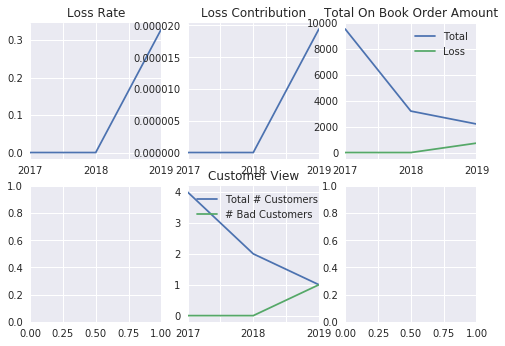

In [278]:
for client_id in list_of_client_ids:
    fig, axes = plt.subplots(nrows=2, ncols=2)
    acct_name = loss_rate[loss_rate['Client ID']==client_id]['Account Name'].values[0]
    print('*=======================*')
    print(acct_name)
    print('*=======================*')
    loss_rate[loss_rate['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Loss Rate',legend = False,ax=axes[0,0])
    loss_contrib[loss_contrib['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Loss Contribution',legend = False,ax=axes[0,0])
    axes[0,0].legend(['Total','Loss'])
    
    total_amt_ob[total_amt_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Total On Book Order Amount',ax=axes[0,2])
    flow_loss[flow_loss['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[0,2])
    axes[0,2].legend(['Total','Loss'])
    
    total_cust_ob[total_cust_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,0])
    flow_cust[flow_cust['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    axes[1,0].legend(['Total # Customers','# Bad Customers'])
    
    total_ord_ob[total_ord_ob['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(title='Customer View',ax=axes[1,0])
    flow_ord[flow_ord['Account Name']==acct_name][['2017','2018','2019']].fillna(0).T.plot(ax=axes[1,0])
    axes[1,0].legend(['Total # Customers','# Bad Customers'])

    plt.show()

In [247]:
pd.DataFrame({'Loss_Rate':loss_rate[loss_rate['Account Name']=='FEDERAL FIRST'][['2017','2018','2019']].values,'Loss Contribution':loss_contrib[loss_contrib['Account Name']=='FEDERAL FIRST'][['2017','2018','2019']].values},index = 0)

TypeError: Index(...) must be called with a collection of some kind, 0 was passed

In [249]:
list(loss_rate[loss_rate['Account Name']=='FEDERAL FIRST'][['2017','2018','2019']].values)

[array([       nan,        nan, 0.32945669])]

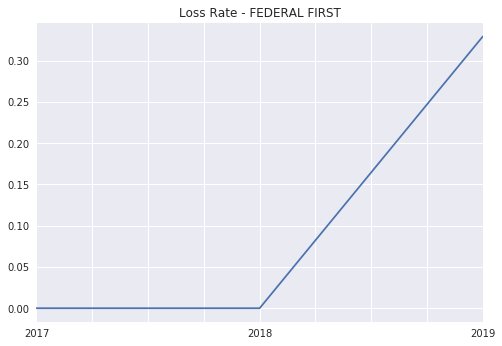

In [239]:

loss_rate[loss_rate['Account Name']=='FEDERAL FIRST'][['2017','2018','2019']].fillna(0).T.plot(title='Loss Rate - FEDERAL FIRST',legend = False)
plt.show()

In [217]:
# plt.plot([2017,2018,2019],loss_rate[loss_rate['Account Name']=='FEDERAL FIRST'][[2017,2018,2019]])

In [179]:
Client[Client['Client ID']==2854]['Account Name'].values[0]

'FEDERAL FIRST'

In [157]:
Client_sub = Client[Client['Account Name'].isin(df_17_w_bad['Account Name'].unique())]

In [167]:
list(Client)

['Active',
 'Client ID',
 'Account Name',
 'Current Eligibles',
 'Eligibles at time of Launch',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'HOST ID',
 'CLIENT CODE',
 'CLIENT NAME',
 'CLIENT AR',
 'TPA_y',
 'Cash']

In [ ]:
def Client_View(Client_ID, annual_vol=True, annual_ord_vol=True, annual_cust_vol=True, flow_loss=True, flow_bad_cust=True, flow_bad_order=True, lost_contrib=True):
    
    